# 1 - The dataset

## Libraries import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from importlib import reload
import optimize
reload(optimize)
# Ignore all warnings to avoid eccessive verbose
import warnings
warnings.filterwarnings('ignore')

#from ydata_profiling import ProfileReport, compare

We used the package `ydata_profiling` to create an HTML page to inspect the dataset and do a brief Explanatory Data Analysis. We added the html file to the same folder of this notebook.

In [3]:
# dataset = pd.read_csv("heart_disease_uci.csv")
# report = ProfileReport(
#     dataset,
#     title="Trending Books",
#     dataset={
#         "description": "This profiling report was generated for the datacamp learning resources.",
#         "author": "Satyam Tripathi",
#         "copyright_holder": "DataCamp, Inc.",
#         "copyright_year": 2023,
#         "url": "<https://www.datacamp.com/>",
#     },
# )
# report.to_notebook_iframe()

In [4]:
# report = ProfileReport(dataset=dataset, title="Heart disease data")
# report.to_file("profile_report.html")

We took the dataset from here: [UCI Heart Disease](https://archive.ics.uci.edu/dataset/45/heart+disease). 

In the original dataset there where 76 attributes that have aready been reduced to 14 main features and the feature indicating the presence of the heart disease. 

Below we print some dataset information, to have a clear view of it.

In [5]:
dataset = pd.read_csv('heart_disease_uci.csv')

dataset.drop('id', axis=1, inplace=True)
dataset

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB


The columns in the dataset represent the following attributes or measured quantities:

- `age` is the age of the person
- `sex` is the sex of the person: _Male / Female_
- `dataset` is a reference to the original dataset, because is a merge of four different datasets made in different countries: _Cleveland / Hungary / Switzerland / VA Long_ Beach
- `cp` stands for chest pain, and that can assume the values: _asymptomatic / atypical angina / non-anginal / typical angina_
- `trestbps` is the resting blood pressure on admission to the hospital (measured in _mmHg_)
- `chol` is the serum cholestoral (measured in _mg / dl_)
- `fbs` stands for fasting blood sugar. It's a boolean value which is true if the measured value is $> 120$ _mg/dl_
- `restecg` is the result of the resting electrocardiographic test: _lv hypertrophy / normal / st-t abnormality_
- `thalch` is the maximum heart rate achieved
- `exang` exercise induced angina: _True / False_
- `oldpeak` is the ST depression induced by exercise relative to rest 
- `slope` is the slope of the peak exercise ST segment : _downsloping / flat / upsloping_ 
- `ca` is the number of major vessels (0-3) colored by flourosopy
- `thal` stands for thalassemia: _fixed defect / normal / reversable defect_
- `num` is the diasgnosis of heart disease: $0$ is negative while $1,2,3,4$ in increasing order identify the severity of the hearth disease    

# 2 - Preprocessing the dataset

## **Categorical variables**

In this section we analize and transform categorical variables. Indeed the treatment of categorical variables holds a significant role in uncovering patterns, drawing insights, and making informed decisions. Categorical variables, which represent qualitative characteristics, often come in the form of labels or groups rather than numerical values. One essential technique in handling these variables is factorization, a process that transforms categorical labels into a numerical format, facilitating their incorporation into mathematical models.


In certain analytical contexts, the decision to encode categorical variables as 0, 1, 2 (and potentially 3) is driven by the need to convey the severity or magnitude of a phenomenon. This encoding scheme is particularly relevant when dealing with variables that exhibit an inherent ordinal nature, where the order among categories implies a certain level of intensity or significance.

In [7]:
# fbs
# 0 = FALSE , 1 = TRUE
dataset['fbs'] = dataset['fbs'].map({False: 0, True: 1})

dataset['fbs'] = pd.to_numeric(dataset['fbs'], errors='coerce')

As can be seen from the pie chart, the `sex` of the patients makes the dataset very unbalanced. We will remedy this problem by using functions that penalize the most represented classes, in this case the males.   

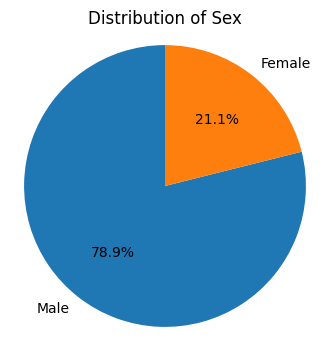

In [8]:
# Pie chart of sex
sex_values = dataset['sex'].value_counts(dropna=False)

plt.figure(figsize=(4,4))
sex_values.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sex')
plt.ylabel('')
plt.axis('equal');

In [9]:
# sex
# Conversion to 0 and 1
# 0 = MALE , 1 = FEMALE
dataset['sex'] = dataset['sex'].map({"Male": 0, "Female": 1})

In [10]:
# exang
# Conversion to 0 and 1
# 0 = FALSE , 1 = TRUE
dataset['exang'] = dataset['exang'].map({False: 0, True: 1})
dataset['exang'] = pd.to_numeric(dataset['exang'], errors='coerce')

Also the `restecg`

The `restecg` column is also very unbalanced, as the number of people with a normal value is much greater than people with abnormalities. In addition, a small slice of missing data can be observed. This will be remedied by interpolating the data, while we will deal with the problem of imbalance later.

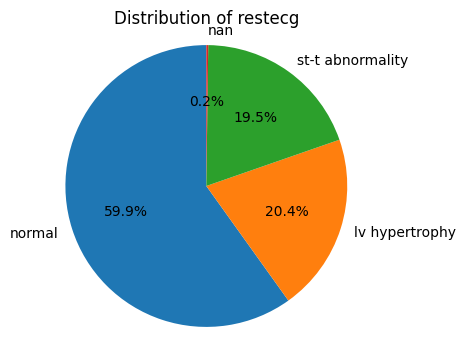

In [11]:
# Pie chart of restecg
restecg_values = dataset['restecg'].value_counts(dropna=False)

plt.figure(figsize=(4,4))
restecg_values.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of restecg')
plt.ylabel('')
plt.axis('equal');

In [12]:
# restecg
# Conversion to 0, 1 and 2 in order of increasing severity
dataset['restecg'] = dataset['restecg'].map({"normal": 0, "st-t abnormality": 1, "lv hypertrophy":2})

For the `slope` column we have some problem. In fact, as it can be observed from the pie chart below, the 33.6% of the values are missing. So we have to interpolate the value.

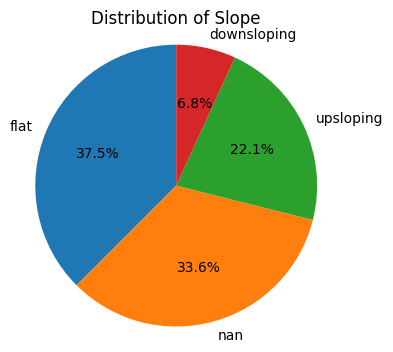

In [13]:
# Pie chart of slope
slope_values = dataset['slope'].value_counts(dropna=False)

plt.figure(figsize=(4,4))
slope_values.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Slope')
plt.ylabel('')
plt.axis('equal');

In [14]:
# slope
# Conversion to 0, 1 and 2 otherwise we cannot interpolate NaN values
dataset['slope'] = dataset['slope'].map({"upsloping": 0, "flat": 1, "downsloping":2})

In [15]:
# cp
# This is an example of ordinal data, where the order of the values is important
# That's why we decided to not use one-hot encoding here
dataset['cp'] = dataset['cp'].map({"asymptomatic": 0, "non-anginal": 1, "typical angina":2, "atypical angina": 3})

In [16]:
# num
# This column is the target value for the classification problem
# Since we only want to predict if a person has a heart attack or not, we can merge the values 2, 3 and 4 (the severity) into 1
# 0 = No heart attack , 1 = Heart attack
dataset['num'] = dataset['num'].map({0: 0, 1: 1, 2:1, 3:1, 4:1})

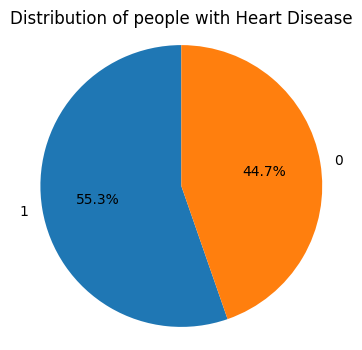

In [17]:
num_counts = dataset['num'].value_counts()

plt.figure(figsize=(4, 4))
num_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of people with Heart Disease')
plt.ylabel('')
plt.axis('equal');

The `num` column is balanced, meaning that there are almost half of people with heart disease and half of the people that are healty. 

In [18]:
nan_percentage = round((dataset.isna().sum() / len(dataset)) * 100,2)
nan_percentage

age          0.00
sex          0.00
dataset      0.00
cp           0.00
trestbps     6.41
chol         3.26
fbs          9.78
restecg      0.22
thalch       5.98
exang        5.98
oldpeak      6.74
slope       33.59
ca          66.41
thal        52.83
num          0.00
dtype: float64

Having analyzed our problem, we no longer consider the following as relevant the features: `thal`, `ca` and `dataset`. In particular we will not focus only on the Cleveland Dataset, as most of the papers about this dataset do, but we will consider together all the four small dataset. This way we are also able to have a bigger training set for training purposes and testing of the various models we will introduce later. Moreover the columns `ca` and `thal` have, respectively, 66.4% and 52.8% of missing values. That is why we decided to eliminate them. In fact, we are interested in values that can be more easily measured by medical analysis, making diagnosis less complex and less expensive. 

In [19]:
dataset = dataset.drop("thal", axis = 1)
dataset = dataset.drop("ca", axis = 1)
dataset = dataset.drop("dataset", axis = 1)

In [20]:
# How the dataset looks like now
dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,num
0,63,0,2,145.0,233.0,1.0,2.0,150.0,0.0,2.3,2.0,0
1,67,0,0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,1.0,1
2,67,0,0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,1.0,1
3,37,0,1,130.0,250.0,0.0,0.0,187.0,0.0,3.5,2.0,0
4,41,1,3,130.0,204.0,0.0,2.0,172.0,0.0,1.4,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,1,0,127.0,333.0,1.0,1.0,154.0,0.0,0.0,NaN,1
916,62,0,2,NaN,139.0,0.0,1.0,NaN,NaN,NaN,NaN,0
917,55,0,0,122.0,223.0,1.0,1.0,100.0,0.0,0.0,NaN,1
918,58,0,0,NaN,385.0,1.0,2.0,NaN,NaN,NaN,NaN,0


# TODO inserire giustificazione linear interpolation (magari inserire plot fatti da Stefano e Marina)

Now we can focus on missing values. In particular, we have decided to interpolate the missing data by the following methodology: 
- `kind ='linear'`: specifies the interpolation method to be used. In this case is a linear interpolation.
- `fill_value = 'extrapolate'`: specifies how to handle values outside the input data range. With this choice, the interpolation function will consider also data point outside of the range of input data. 

In [21]:
# Retrive the index list
index_list = dataset.index.tolist()

# List of the columns to be interpolated
not_nan_columns = ['slope', 'trestbps', 'fbs', 'chol', 'restecg', 'thalch', 'exang', 'oldpeak']

for column in not_nan_columns:
  not_nan = dataset[column].notna()
  interpolated_values = interp1d(np.array(index_list)[not_nan], dataset[column][not_nan], kind='linear', fill_value='extrapolate')
  dataset[column] = np.where(not_nan, dataset[column], interpolated_values(index_list))


In [22]:
dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,num
count,920.000000,920.000000,920.00000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,53.510870,0.210870,0.88913,132.365761,200.819022,0.161413,0.603261,136.693478,0.403261,0.903315,0.817391,0.553261
std,9.424685,0.408148,1.15534,18.791291,109.720595,0.361838,0.805443,25.635394,0.486551,1.094348,0.565933,0.497426
min,28.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,0.000000,0.00000,120.000000,177.750000,0.000000,0.000000,119.250000,0.000000,0.000000,0.283730,0.000000
50%,54.000000,0.000000,0.00000,130.000000,224.000000,0.000000,0.000000,138.000000,0.000000,0.500000,1.000000,1.000000
75%,60.000000,0.000000,1.00000,141.375000,268.000000,0.000000,1.000000,156.000000,1.000000,1.600000,1.000000,1.000000
max,77.000000,1.000000,3.00000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,1.000000


Now that we have removed all the NaN values we can normalize the dataset, so that we can optimize all the parameter optimization methods and speed up model training. Obviously we are not going to normalize the categorical values that assume boolean values 0 and 1. We will also not normalize categorical variables where the associated integer value indicates greater symptom severity. 

In [23]:
numerical_columns = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'slope']
scaler = MinMaxScaler()
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

In [24]:
from sklearn.preprocessing import LabelEncoder


cat_vars = ['cp', 'restecg']

label_encoder = LabelEncoder()
for col in cat_vars:
    dataset[col] = label_encoder.fit_transform(dataset[col])
dataset[cat_vars] = scaler.fit_transform(dataset[cat_vars])

In [25]:
# How the dataset looks like now
dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,num
0,0.714286,0,0.666667,0.7250,0.386401,1.0,1.0,0.633803,0.0,0.556818,1.0,0
1,0.795918,0,0.000000,0.8000,0.474295,0.0,1.0,0.338028,1.0,0.465909,0.5,1
2,0.795918,0,0.000000,0.6000,0.379768,0.0,1.0,0.485915,1.0,0.590909,0.5,1
3,0.183673,0,0.333333,0.6500,0.414594,0.0,0.0,0.894366,0.0,0.693182,1.0,0
4,0.265306,1,1.000000,0.6500,0.338308,0.0,1.0,0.788732,0.0,0.454545,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.530612,1,0.000000,0.6350,0.552239,1.0,0.5,0.661972,0.0,0.295455,0.5,1
916,0.693878,0,0.666667,0.6225,0.230514,0.0,0.5,0.471831,0.0,0.295455,0.5,0
917,0.551020,0,0.000000,0.6100,0.369818,1.0,0.5,0.281690,0.0,0.295455,0.5,1
918,0.612245,0,0.000000,0.6050,0.638474,1.0,1.0,0.257042,0.5,0.295455,0.5,0


In [26]:
dataset.describe()  

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,num
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,0.520630,0.210870,0.296377,0.661829,0.333033,0.161413,0.301630,0.540095,0.403261,0.398104,0.408696,0.553261
std,0.192341,0.408148,0.385113,0.093956,0.181958,0.361838,0.402721,0.180531,0.486551,0.124358,0.282967,0.497426
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.387755,0.000000,0.000000,0.600000,0.294776,0.000000,0.000000,0.417254,0.000000,0.295455,0.141865,0.000000
50%,0.530612,0.000000,0.000000,0.650000,0.371476,0.000000,0.000000,0.549296,0.000000,0.352273,0.500000,1.000000
75%,0.653061,0.000000,0.333333,0.706875,0.444444,0.000000,0.500000,0.676056,1.000000,0.477273,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we will split the dataset in:
- the matrix of features $X$ 
- the matrix of the labels $y$

In [27]:
X = dataset.drop('num', axis=1)
y = dataset['num']

print(f"The shape of X is: {X.shape}")
print(f"The shape of y is: {y.shape}")

The shape of X is: (920, 11)
The shape of y is: (920,)


## Correlation among the features

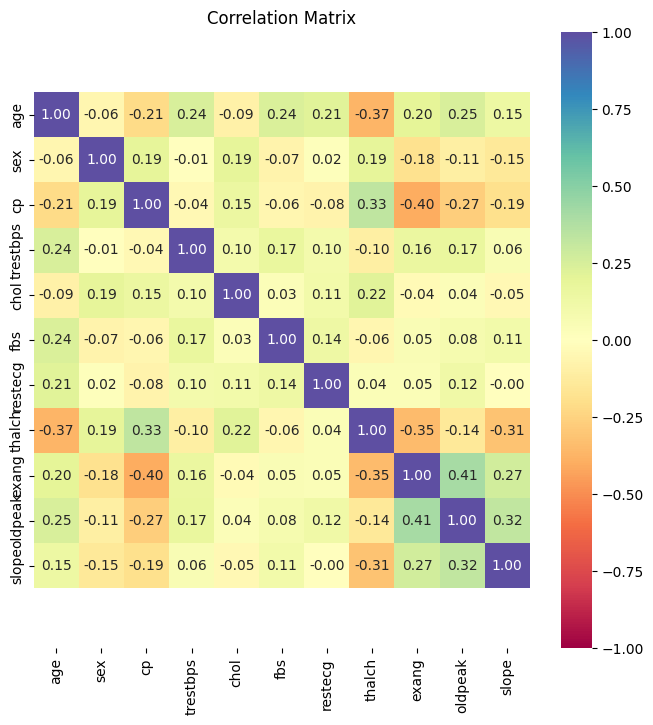

In [28]:
# Correlation matrix of the features

plt.figure(figsize=(8,8))
sns.heatmap(X.corr(), annot=True, cmap='Spectral', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.axis('equal');

As can be seen from the correlation matrix, there is no explicit linear dependence between the various features. This is good since we otherwise may run into overfitting or underfitting more easily. In such cases the model will fails to capture the true relationship with the real target label because of collinear predictors.

# Logistic Regression

First of all we train a Logistic Regression model with various choices for the parameter. In particular we consider:
- the regularization function that can be _L2 / elasticnet_. For elasticnet we will specify different ratio for the L1 and L2 distances
- the regularization parameter (we will use parameters of different scales)

We will use the K-Fold cross validation procedure in wich we consideer $K=5$. In doing this we are considering $80\%$ of the dataset as training set for the cross validation procedure, while the remaining $20\%$ will be used for testing purpose. 

Best Parameters: {'C': 1, 'l1_ratio': 0.0, 'penalty': 'l2'}
AUC Score: 0.887510437790767
F1 Score: 0.814996465182043
--------------------------------------------------
Best Parameters: {'C': 0.1, 'l1_ratio': 0.0, 'penalty': 'l2'}
AUC Score: 0.8920373027259685
F1 Score: 0.8043478260869565
--------------------------------------------------
Best Parameters: {'C': 0.1, 'l1_ratio': 0.0, 'penalty': 'l2'}
AUC Score: 0.868364418938307
F1 Score: 0.7773003108835191
--------------------------------------------------
Best Parameters: {'C': 0.1, 'l1_ratio': 0.0, 'penalty': 'l2'}
AUC Score: 0.8258010521281682
F1 Score: 0.7447101124762294
--------------------------------------------------
Best Parameters: {'C': 0.1, 'l1_ratio': 0.0, 'penalty': 'l2'}
AUC Score: 0.8727881396461022
F1 Score: 0.8139658400117793
--------------------------------------------------


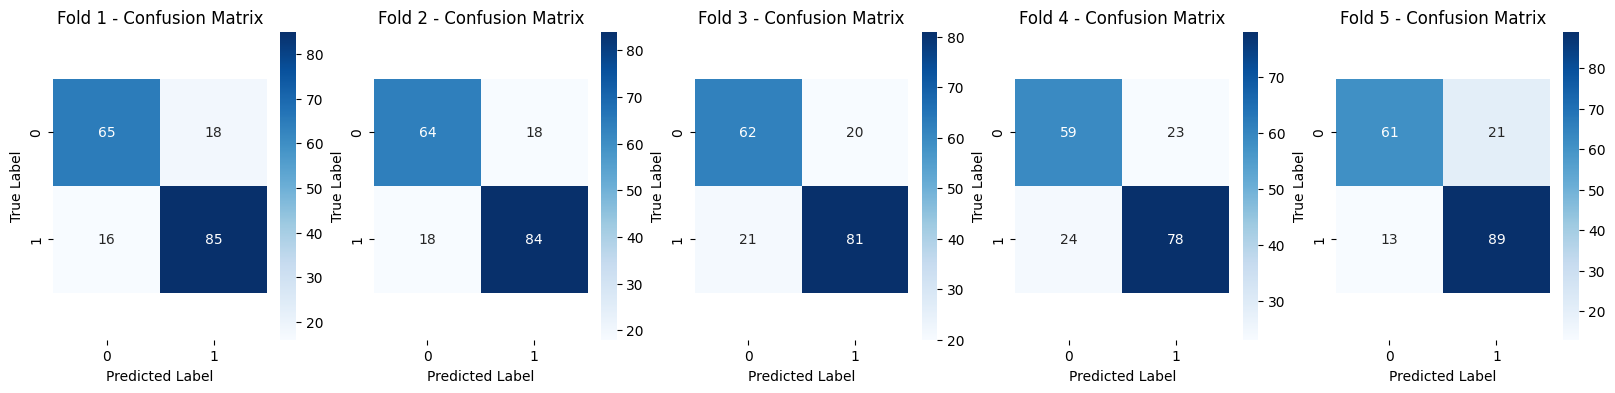

In [25]:
# Create the model with class weights balanced to deal with the imbalanced dataset
model = LogisticRegression(class_weight = "balanced")

# Setting up the hyperparameter grid for GridSearchCV
param_grid = {
    'penalty' : ['l2', 'elasticnet'],
    'l1_ratio' : np.linspace(0,1,11),
    'C': [0.001, 0.01, 0.1, 1, 10, 100]# Regularization parameter
}

df_metrics = optimize.run(model, param_grid, X, y)

f1           0.791064
auc            0.8693
accuracy     0.791304
precision    0.791514
dtype: object


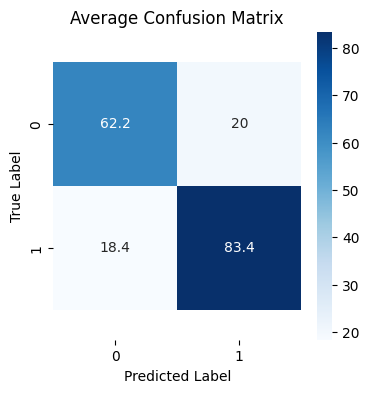

In [27]:
optimize.print_statistics(df_metrics)

To get the real scores for this model we have to average over all the folds, so that we have has best score for the logistic model:
- `F1` : $0.79$
- `AUC-ROC` : $0.87$ 
- `Accuracy` : $0.79$
- `Precision` : $0.79$

We can see that the best models are for the L2 regularization. We now try to fix it and to search for a better regularization parameter in range $[0,1]$ instead.

Best Parameters: {'C': 0.5742999999999999}
AUC Score: 0.8888226172014791
F1 Score: 0.8096747081004952
--------------------------------------------------
Best Parameters: {'C': 0.09909999999999998}
AUC Score: 0.8919177427068389
F1 Score: 0.8096630646221107
--------------------------------------------------
Best Parameters: {'C': 0.2773}
AUC Score: 0.8687230989956959
F1 Score: 0.7883655142667294
--------------------------------------------------
Best Parameters: {'C': 0.208}
AUC Score: 0.8320181731229077
F1 Score: 0.7289390064326126
--------------------------------------------------
Best Parameters: {'C': 0.10899999999999999}
AUC Score: 0.8735054997608799
F1 Score: 0.8143486123122888
--------------------------------------------------


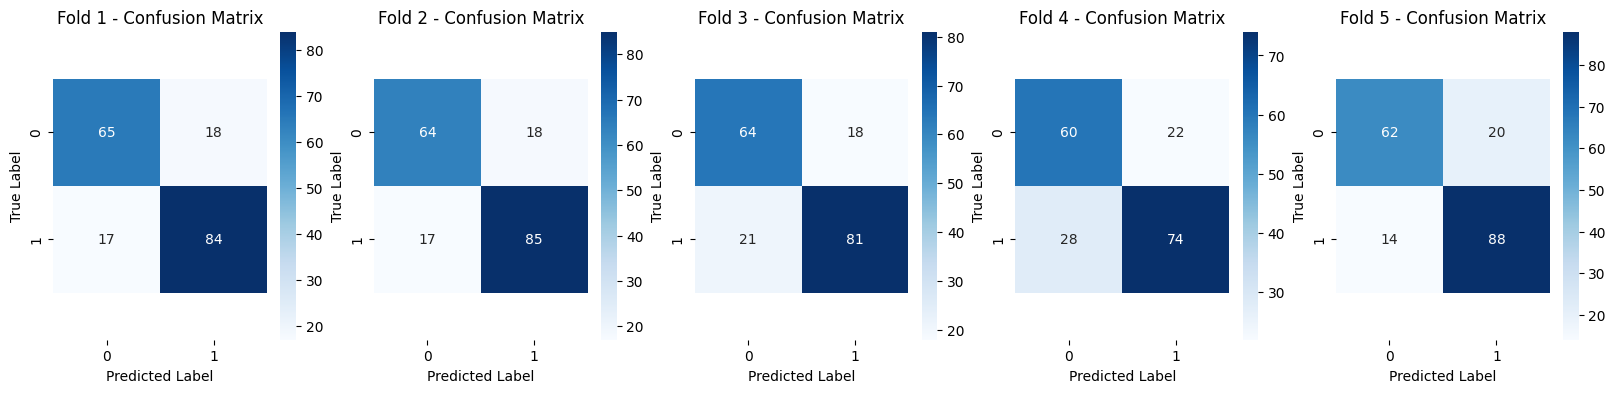

In [28]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

# Create the model with class weights balanced to deal with the imbalanced dataset
model = LogisticRegression(class_weight="balanced", penalty = 'l2')

# Setting up the hyperparameter grid for GridSearchCV
param_grid = {
    'C': np.linspace(0.01, 1, 101)  # Regularization parameter
}

df_metrics = optimize.run(model, param_grid, X, y)

f1           0.790198
auc          0.870997
accuracy     0.790217
precision    0.790945
dtype: object


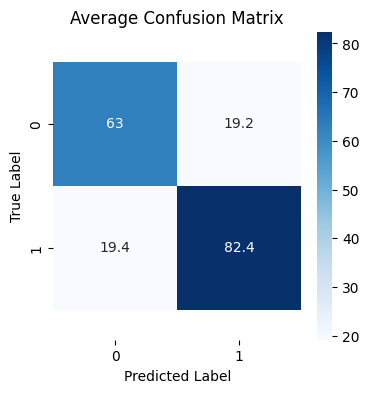

In [29]:
optimize.print_statistics(df_metrics)

The scores for this model, considering the refined research, are:
- `F1` : $0.79$
- `AUC-ROC` : $0.87$ 
- `Accuracy` : $0.79$
- `Precision` : $0.79$

In [51]:
reload(optimize)

<module 'optimize' from 'c:\\Users\\bergi\\OneDrive\\Desktop\\Università\\Magistrale\\FDS\\Homeworks\\Final proj\\optimize.py'>

Best Parameters: {'C': 10}
AUC Score: 0.8883454610521294
F1 Score: 0.793819794138805
--------------------------------------------------
Best Parameters: {'C': 0.1}
AUC Score: 0.8950263032042085
F1 Score: 0.7935319752711056
--------------------------------------------------
Best Parameters: {'C': 0.1}
AUC Score: 0.859636537541846
F1 Score: 0.7467911374337023
--------------------------------------------------
Best Parameters: {'C': 0.1}
AUC Score: 0.8316594930655189
F1 Score: 0.7728596455304529
--------------------------------------------------
Best Parameters: {'C': 0.01}
AUC Score: 0.867168818747011
F1 Score: 0.6832315296972318
--------------------------------------------------


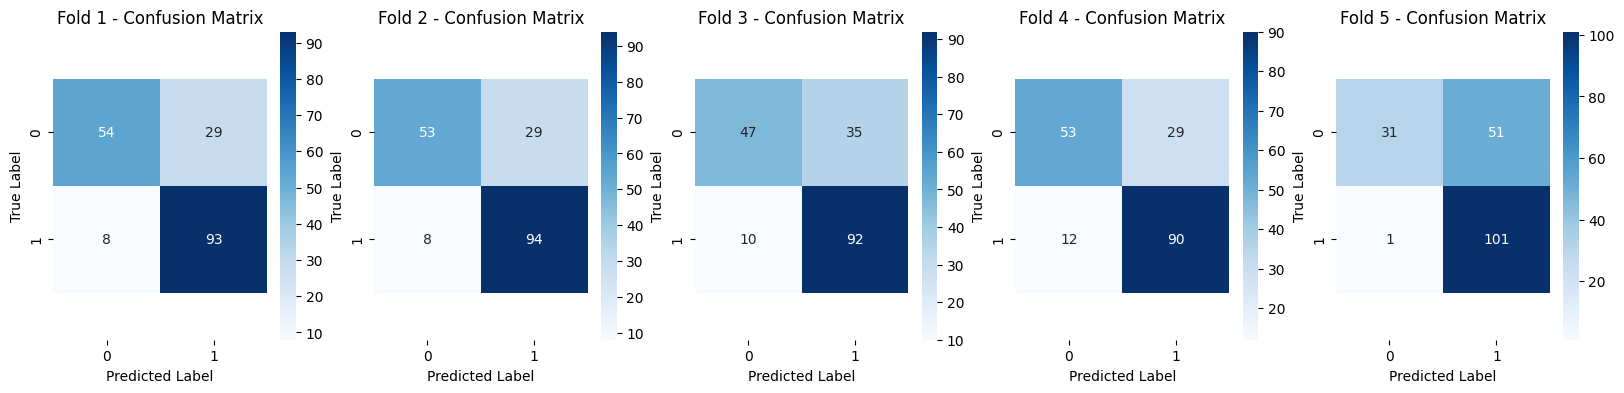

In [110]:
# Create the model with class weights balanced to deal with the imbalanced dataset
model = LogisticRegression(class_weight = {0:1, 1:1.5})

# Setting up the hyperparameter grid for GridSearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
}

df_metrics = optimize.run(model, param_grid, X, y)

f1           0.781679
auc          0.870568
accuracy     0.788043
precision    0.802401
dtype: object


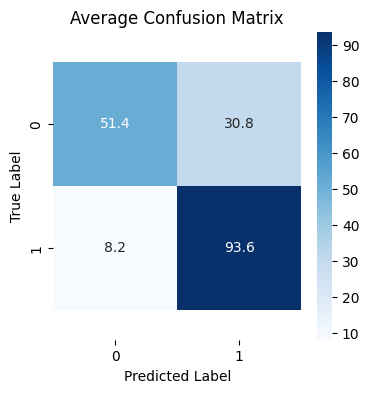

In [68]:
optimize.print_statistics(df_metrics)

The scores for this model, considering the refined research, are:
- `F1` : $0.78$
- `AUC-ROC` : $0.87$ 
- `Accuracy` : $0.78$
- `Precision` : $0.80$

But here few FN.

# LDA

In [ ]:
# Defining the LDA LDA
LDA = LinearDiscriminantAnalysis()
# Defining the Logistic Regression LDA
# model = LogisticRegression(class_weight="balanced", penalty = 'l2', C = 0.01)

k = 5
kf = StratifiedKFold(n_splits = k, random_state = 42, shuffle=True)

# Dataframe to store metrics and parameters
df_metrics = pd.DataFrame(columns = ['f1', 'auc', 'accuracy','precision','conf_matrix', 'TP', 'TN', 'FP', 'FN'])

for i, (train_ids, test_ids) in enumerate(kf.split(X, y)):
    X_train = X.iloc[train_ids]
    X_test = X.iloc[test_ids]
    y_train = y.iloc[train_ids]
    y_test = y.iloc[test_ids]
        
    # Fitting the LDA LDA on the training data
    LDA.fit(X_train, y_train)
    
    # # Transforming the data in order to reduce the dimensionality
    # X_train = LDA.transform(X_train)
    # X_test = LDA.transform(X_test)

    # Fitting the Logistic Regression LDA on the training data
    LDA.fit(X_train, y_train)

    # Predicting probabilities
    y_pred_proba = LDA.predict_proba(X_test)[:, 1]

    # Calculating AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    # Calculating F1 score
    y_pred = LDA.predict(X_test)
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Saving metrics
    row = pd.Series()
    row['f1'] = f1
    row['auc'] = roc_auc
    row['accuracy'] = accuracy
    row['precision'] = precision
    row['conf_matrix'] = conf_matrix
    row['TP'] = conf_matrix[1][1]
    row['TN'] = conf_matrix[0][0]
    row['FP'] = conf_matrix[0][1]
    row['FN'] = conf_matrix[1][0]
    df_metrics = pd.concat([df_metrics, pd.DataFrame(row).transpose()]).reset_index(drop=True)

In [ ]:
optimize.print_statistics(df_metrics)

The scores for this model, considering the refined research, are:
- `F1` : $0.80$
- `AUC-ROC` : $0.88$ 
- `Accuracy` : $0.75$
- `Precision` : $0.79$

# Random Forest

In [ ]:
# Defining the Random Forest model
model = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight="balanced")

# Setting up hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 20, 100],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20, 30],  # Maximum depth of the tree
    #'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

df_metrics = optimize.run(model, param_grid, X, y)

In [ ]:
optimize.print_statistics(df_metrics)

The scores for this model, considering the refined research, are:
- `F1` : $0.81$
- `AUC-ROC` : $0.89$ 
- `Accuracy` : $0.81$
- `Precision` : $0.81$

These score are a bit better than the scores obtained using Logistic Regression.

# SVM

In [ ]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

# Create the model with class weights balanced to deal with the imbalanced dataset
model = SVC(class_weight={0:1, 1:2}, probability=True, random_state=42)

# Setting up the hyperparameter grid for GridSearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [1, 2, 3, 4, 5, 6]
}

df_metrics = optimize.run(model, param_grid, X, y)


In [ ]:
optimize.print_statistics(df_metrics)

To get the real scores for this model we have to average over all the folds, so that we have has best score for the logistic model:
- `F1` : $0.75$
- `AUC-ROC` : $0.87$ 
- `Accuracy` : $0.76$
- `Precision` : $0.78$

We can see that the best models are for the L2 regularization. We now try to fix it and to search for a better regularization parameter in range $[0,1]$ instead.

In [ ]:
# Create the model with class weights balanced to deal with the imbalanced dataset
model = SVC(class_weight="balanced", probability=True, random_state=42)

# Setting up the hyperparameter grid for GridSearchCV
param_grid = {
    'C': np.linspace(0,1,11),  # Regularization parameter
    'kernel': ['poly'],
    'gamma': ['scale'],
    'degree': [1]
}

df_metrics = optimize.run(model, param_grid, X, y)

In [ ]:
# print statistics
optimize.print_statistics(df_metrics)

To get the real scores for this model we have to average over all the folds, so that we have has best score for the logistic model:
- `F1` : $0.78$
- `AUC-ROC` : $0.87$ 
- `Accuracy` : $0.80$
- `Precision` : $0.80$

We can see that the best models are for the L2 regularization. We now try to fix it and to search for a better regularization parameter in range $[0,1]$ instead.

# Convolutional Neural Network

Now we build the CNN. We will use the following architecture, proposed by [this paper](https://www.mdpi.com/2227-9059/10/11/2796):
- 2 Convolutional layers with 128 filters, with kernel size of 3
- 4 Dense layers with 128 neurons
- 4 Dense layers with 64 neurons
- 1 Output layer with 1 neuron 

We will use the `elu` activation function and the `MaxPooling` with pool size of 2. 
As loss function we will use the `binary crossentropy`, since we have a binary classification problem and since it is what was suggested by the paper. We will use the `Nadam` optimizer, since this is what the author used too. 

As before we will use the K-Fold cross validation procedure in wich we consideer $K=5$. In doing this we are considering $70\%$ of the dataset as training set , while the remaining $30\%$ will be used for validation and testing purpose.

 To avoid overfitting we will use dropouts of ranodm units in the hidden layers of the network as well as the early stopping callback, which will stop the training if the validation loss does not improve for 20 epochs. We will also use the `ReduceLROnPlateau` callback, which will reduce the learning rate by a factor of 0.2 if the validation loss does not improve for 5 epochs. Moreover, we will use the `ModelCheckpoint` callback, which will save the best model found during the training based on validation loss and will restore it at the end of the training. 

 In the optimizer function we decided to use class weights of 1 for class 0 (healthy) and 1.5 for class 1 (hearth disease). This is partly because the dataset is slightly unbalanced, but mainly because we want to minimize the false negatives and by increasing the weight of the first class we are penalizing the prediction of a sick person as healthy more than the prediction of a healthy person as sick, thus we are penalizing the false negatives more. In other words, by assigning different class weights in the optimizer function, we are adjusting the importance of each class during the training process. A higher weight for class 1 (heart disease) signals that misclassifying instances of this class is more costly than misclassifying instances of class 0 (healthy).

 Finally we are also choosing a probability threshold of $0.49$ for classification as sick. Doing so we hope to collect those instances in which the model was less sure of the prediction as healthy and to classify them as sick since the consequences of this misclassification are more serious than the opposite.

3/3 [==============================] - 2s 18ms/step - loss: 0.3348 - recall: 0.8889 - auc: 0.9163 - false_negatives: 5.0000 - accuracy: 0.8630
Test Recall: 0.8888888955116272
Test AUC: 0.916269838809967
Test FN: 5.0
Test Accuracy: 0.8630136847496033
3/3 [==============================] - 1s 29ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.89      0.89      0.89        45

    accuracy                           0.86        73
   macro avg       0.86      0.86      0.86        73
weighted avg       0.86      0.86      0.86        73



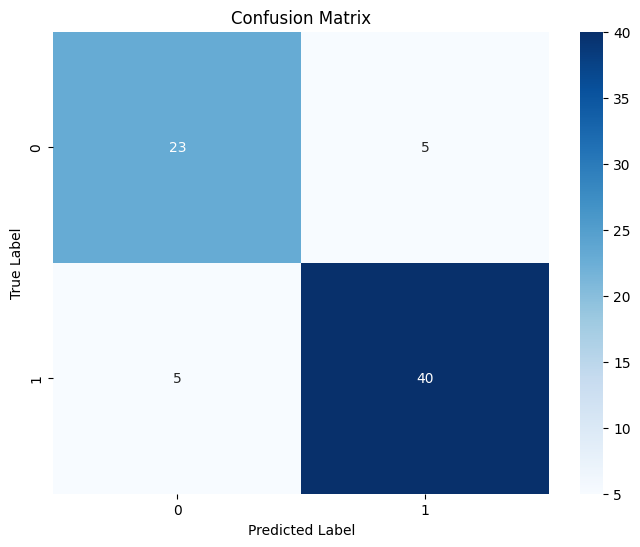

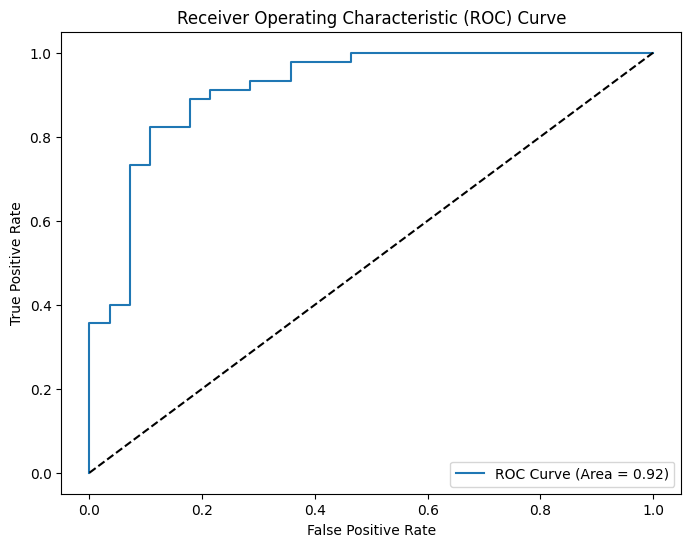

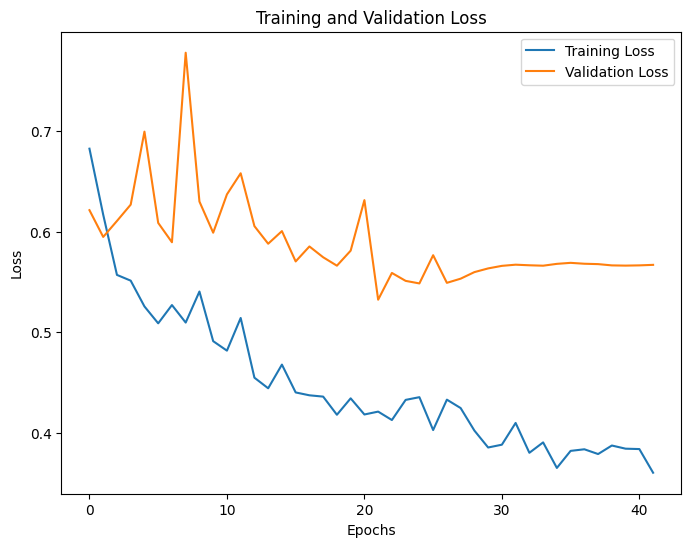

3/3 [==============================] - 2s 17ms/step - loss: 0.5051 - recall: 0.8537 - auc: 0.8563 - false_negatives: 6.0000 - accuracy: 0.8219
Test Recall: 0.8536585569381714
Test AUC: 0.8563262224197388
Test FN: 6.0
Test Accuracy: 0.8219178318977356
3/3 [==============================] - 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.84      0.88      0.86        41

    accuracy                           0.84        73
   macro avg       0.84      0.83      0.83        73
weighted avg       0.84      0.84      0.83        73



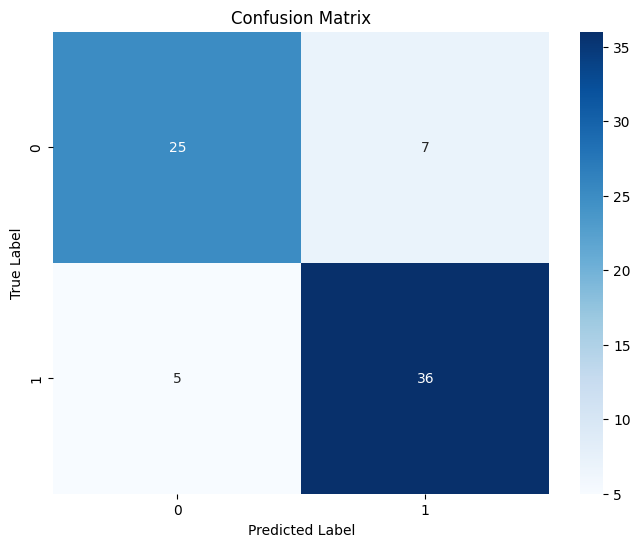

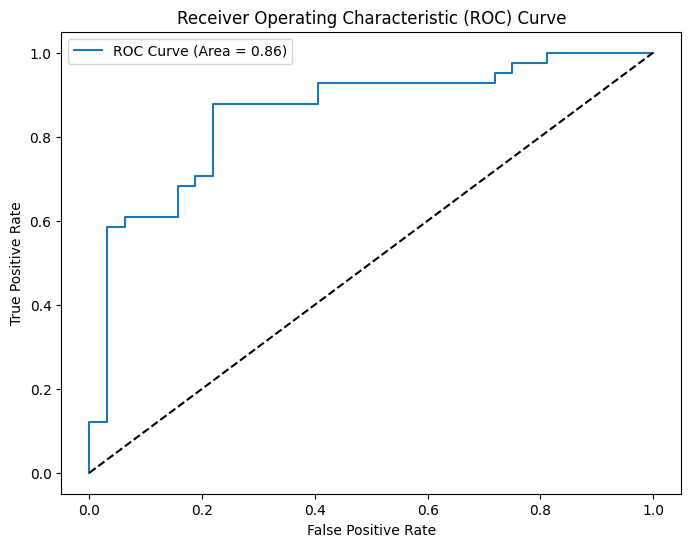

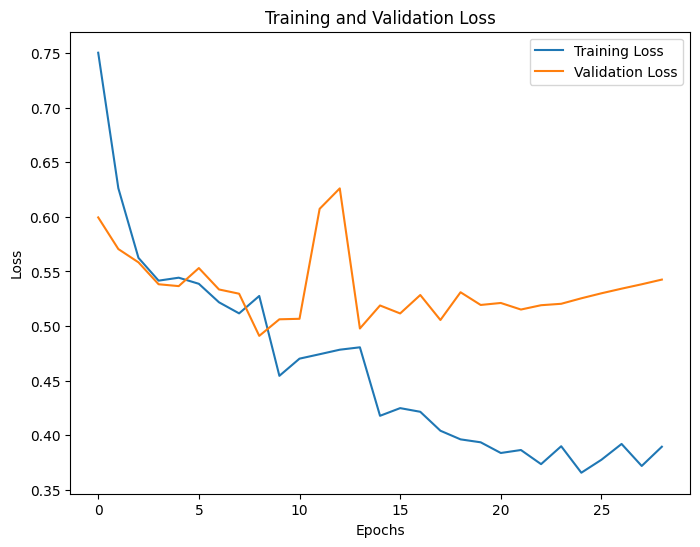

3/3 [==============================] - 2s 13ms/step - loss: 0.4412 - recall: 0.9535 - auc: 0.8628 - false_negatives: 2.0000 - accuracy: 0.8219
Test Recall: 0.9534883499145508
Test AUC: 0.8627906441688538
Test FN: 2.0
Test Accuracy: 0.8219178318977356
3/3 [==============================] - 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.63      0.75        30
           1       0.79      0.95      0.86        43

    accuracy                           0.82        73
   macro avg       0.85      0.79      0.80        73
weighted avg       0.84      0.82      0.81        73



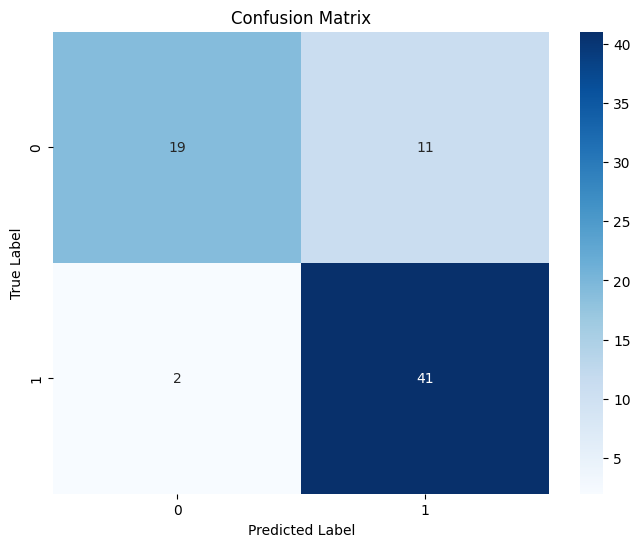

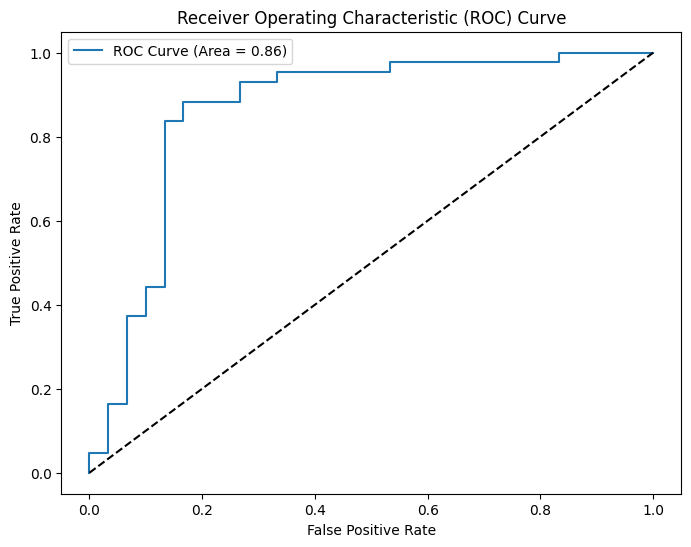

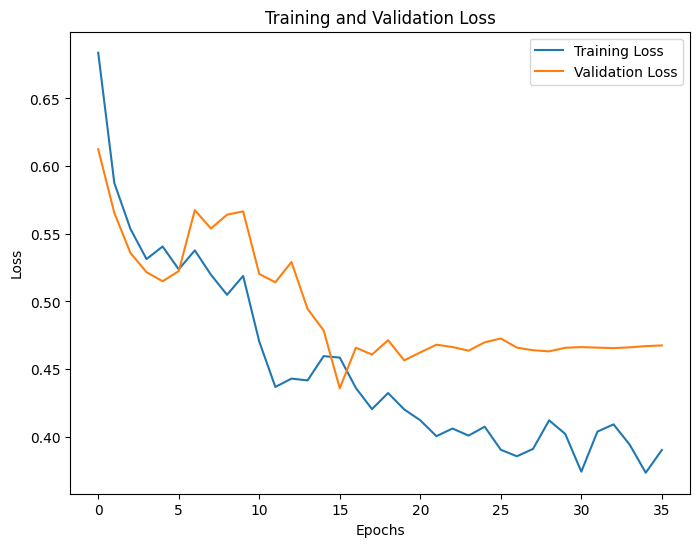

3/3 [==============================] - 1s 11ms/step - loss: 0.4573 - recall: 0.8043 - auc: 0.8535 - false_negatives: 9.0000 - accuracy: 0.7534
Test Recall: 0.804347813129425
Test AUC: 0.8534621596336365
Test FN: 9.0
Test Accuracy: 0.7534246444702148
3/3 [==============================] - 0s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        27
           1       0.81      0.83      0.82        46

    accuracy                           0.77        73
   macro avg       0.75      0.75      0.75        73
weighted avg       0.77      0.77      0.77        73



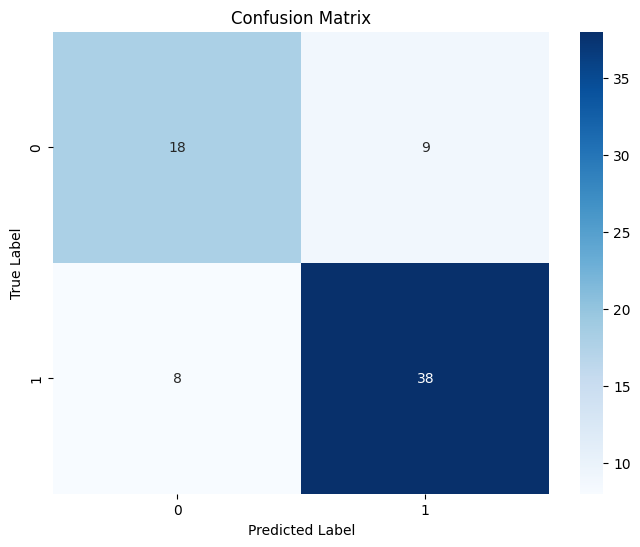

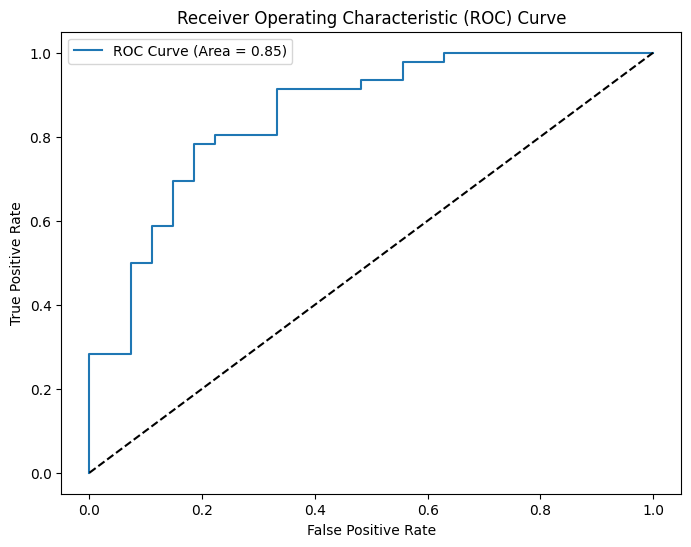

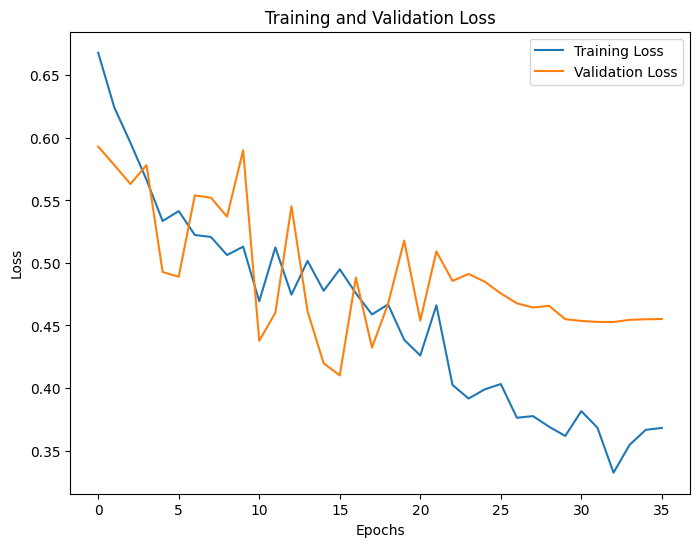

3/3 [==============================] - 1s 9ms/step - loss: 0.4346 - recall: 0.9250 - auc: 0.8769 - false_negatives: 3.0000 - accuracy: 0.8082
Test Recall: 0.925000011920929
Test AUC: 0.8768938779830933
Test FN: 3.0
Test Accuracy: 0.8082191944122314
3/3 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.67      0.77        33
           1       0.78      0.95      0.85        40

    accuracy                           0.82        73
   macro avg       0.85      0.81      0.81        73
weighted avg       0.84      0.82      0.82        73



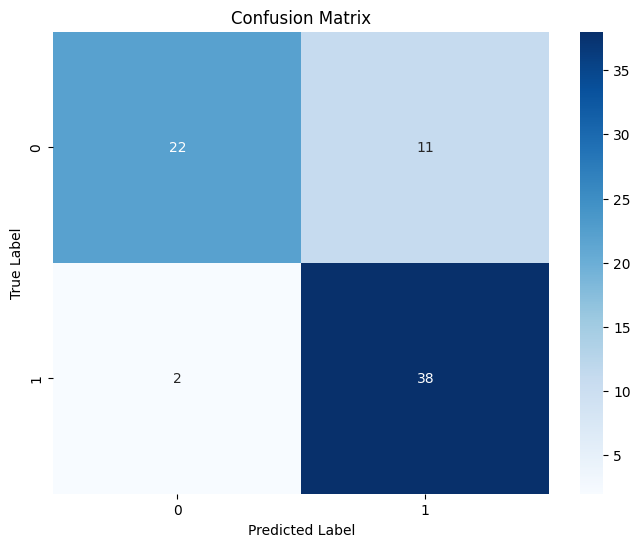

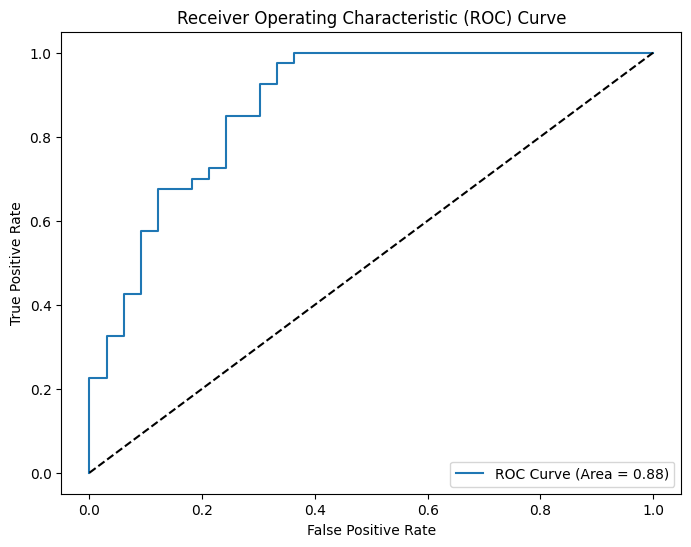

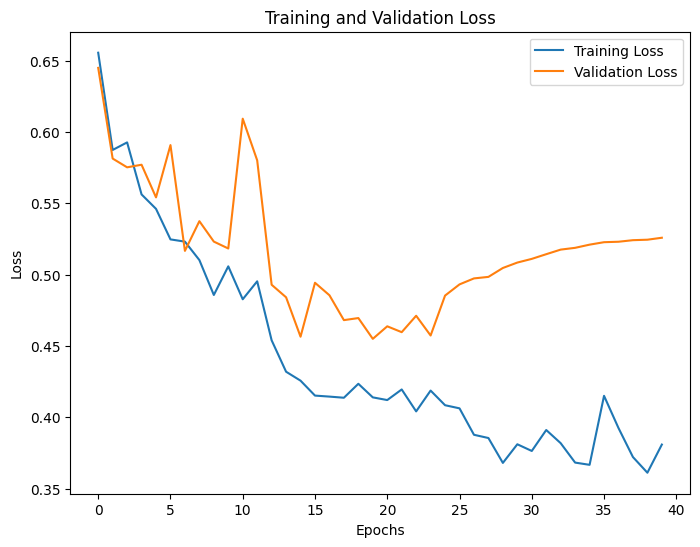

Mean AUC: 0.8731 (+/- 0.0230)
Mean F1 Score: 0.8191 (+/- 0.0316)
Mean FN Rate: 0.0603 (+/- 0.0308)
Mean Accuracy: 0.8137 (+/- 0.0353)


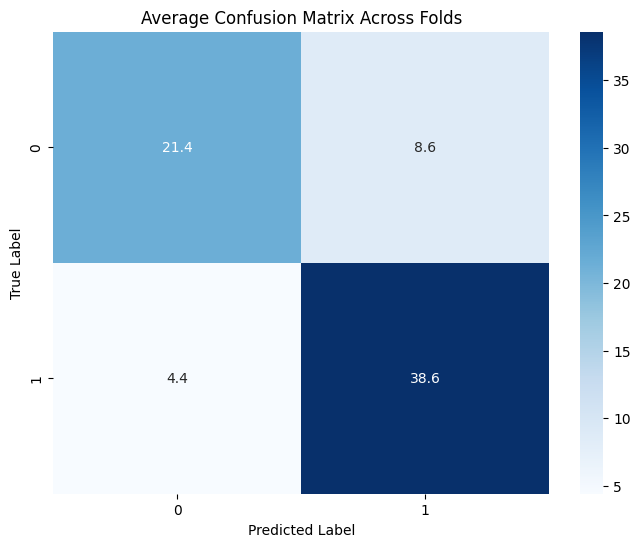

In [37]:
# Number of folds for Stratified K-fold
n_splits = 5

# Weights of the classes
class_weight = {0: 1, 1: 1.5}

optimize.CV_NN_stats(X, y, n_splits, class_weight, 'CNN')

warnings.filterwarnings('ignore')

From these reuslts we can notice that, even if the CNN was trained on tabular data, it performed better than the other models. This is probably due to the fact that the CNN is able to capture more complex patterns in the data, probably correlations between features that are not linear or hierarchical structures in the data.

## Neural Network

The structure of the neural network is the following:
- 4 Dense layers with 128 neurons
- 4 Dense layers with 64 neurons
- 1 Output layer with 1 neuron

It is very similar to the CNN, but it does not have the convolutional layers. All the other parameters are the same as before.

3/3 [==============================] - 1s 8ms/step - loss: 0.3442 - recall: 0.8889 - auc: 0.9238 - false_negatives: 5.0000 - accuracy: 0.8493
Test Recall: 0.8888888955116272
Test AUC: 0.9238095283508301
Test FN: 5.0
Test Accuracy: 0.8493150472640991
3/3 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        28
           1       0.87      0.89      0.88        45

    accuracy                           0.85        73
   macro avg       0.84      0.84      0.84        73
weighted avg       0.85      0.85      0.85        73



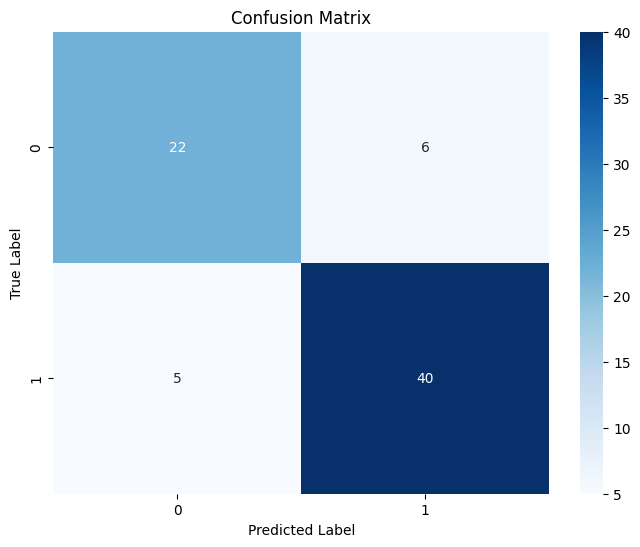

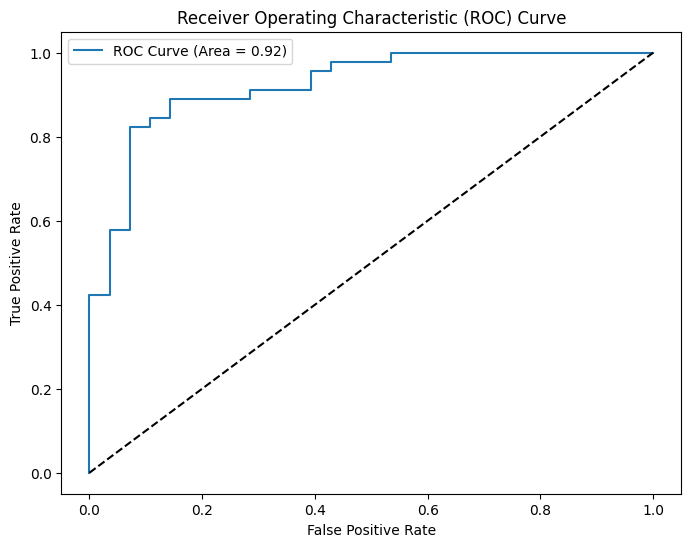

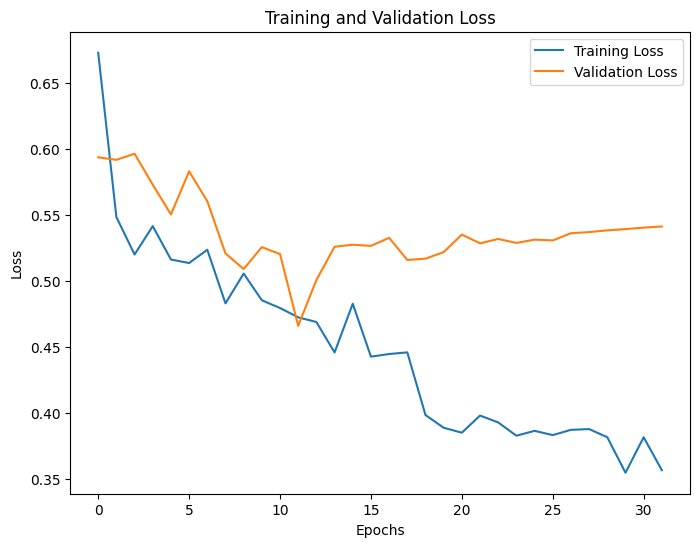

3/3 [==============================] - 2s 13ms/step - loss: 0.4983 - recall: 0.8780 - auc: 0.8502 - false_negatives: 5.0000 - accuracy: 0.7945
Test Recall: 0.8780487775802612
Test AUC: 0.8502286672592163
Test FN: 5.0
Test Accuracy: 0.7945205569267273
3/3 [==============================] - 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75        32
           1       0.78      0.88      0.83        41

    accuracy                           0.79        73
   macro avg       0.80      0.78      0.79        73
weighted avg       0.80      0.79      0.79        73



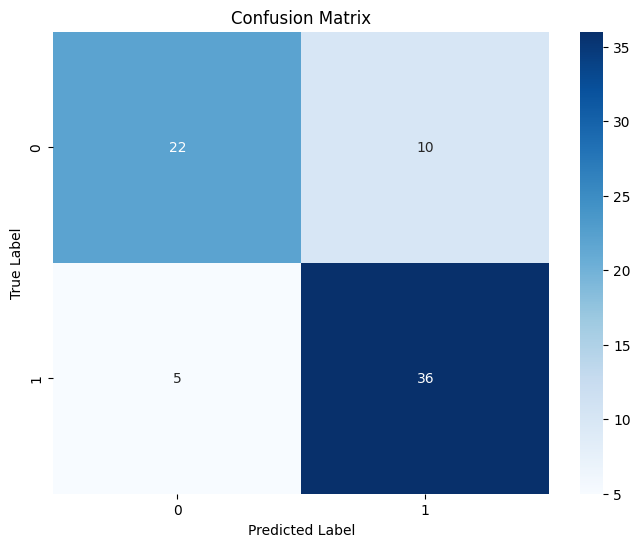

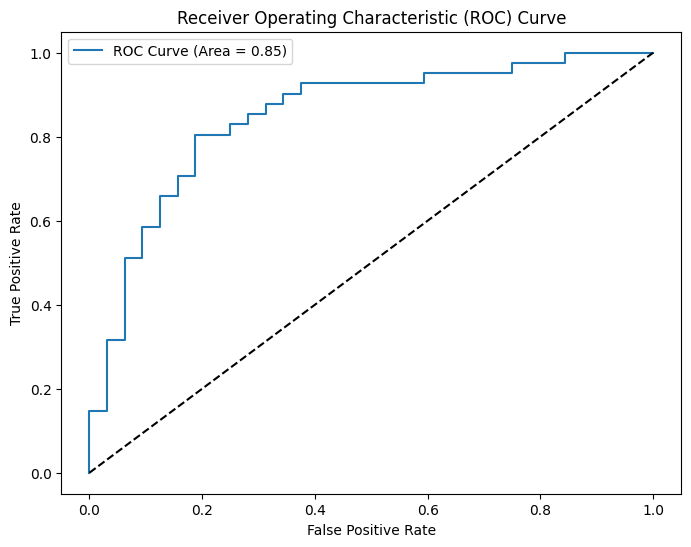

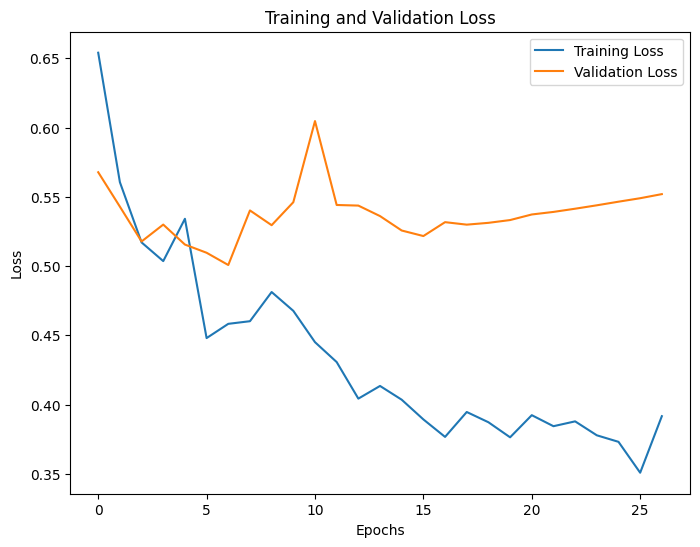

3/3 [==============================] - 1s 14ms/step - loss: 0.4611 - recall: 0.8140 - auc: 0.8682 - false_negatives: 8.0000 - accuracy: 0.8082
Test Recall: 0.8139534592628479
Test AUC: 0.8682170510292053
Test FN: 8.0
Test Accuracy: 0.8082191944122314
3/3 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        30
           1       0.85      0.81      0.83        43

    accuracy                           0.81        73
   macro avg       0.80      0.81      0.80        73
weighted avg       0.81      0.81      0.81        73



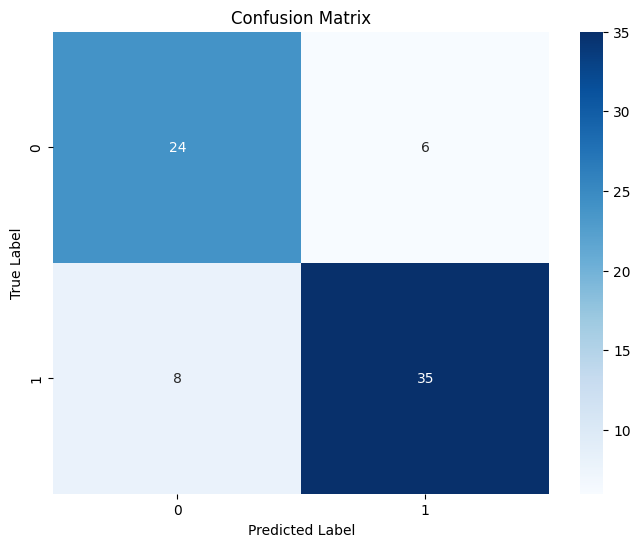

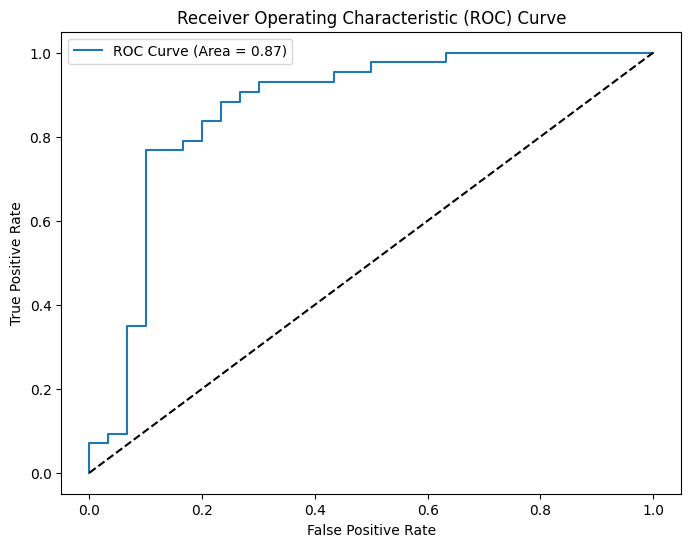

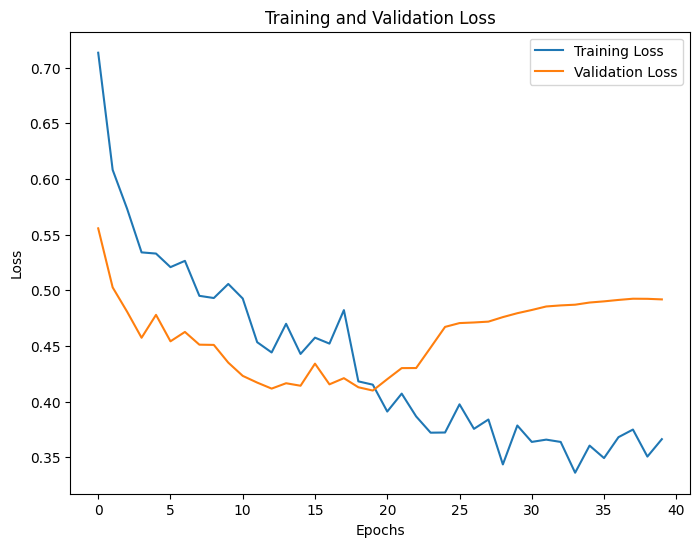

3/3 [==============================] - 1s 14ms/step - loss: 0.4255 - recall: 0.7826 - auc: 0.8837 - false_negatives: 10.0000 - accuracy: 0.7945
Test Recall: 0.782608687877655
Test AUC: 0.8836554288864136
Test FN: 10.0
Test Accuracy: 0.7945205569267273
3/3 [==============================] - 1s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.78      0.72        27
           1       0.86      0.78      0.82        46

    accuracy                           0.78        73
   macro avg       0.77      0.78      0.77        73
weighted avg       0.79      0.78      0.78        73



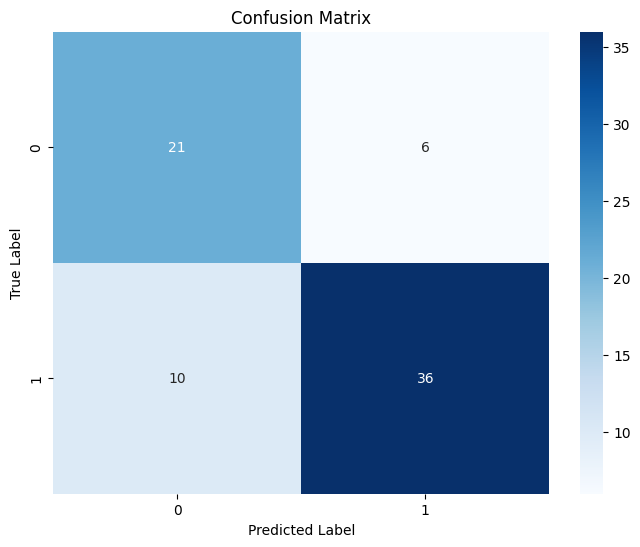

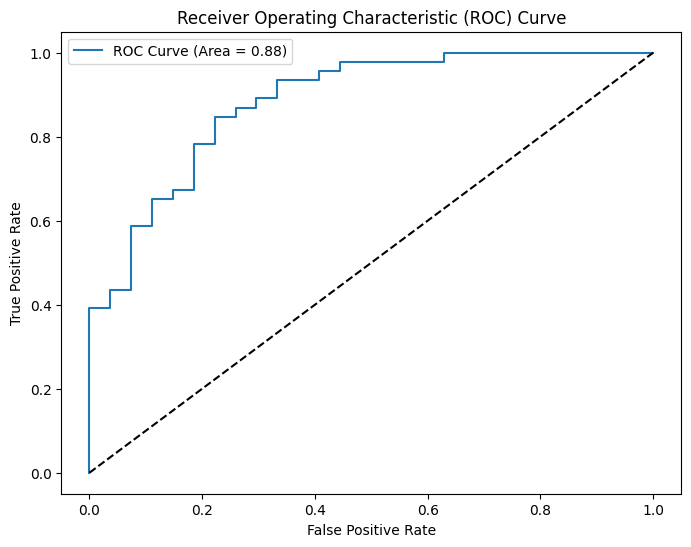

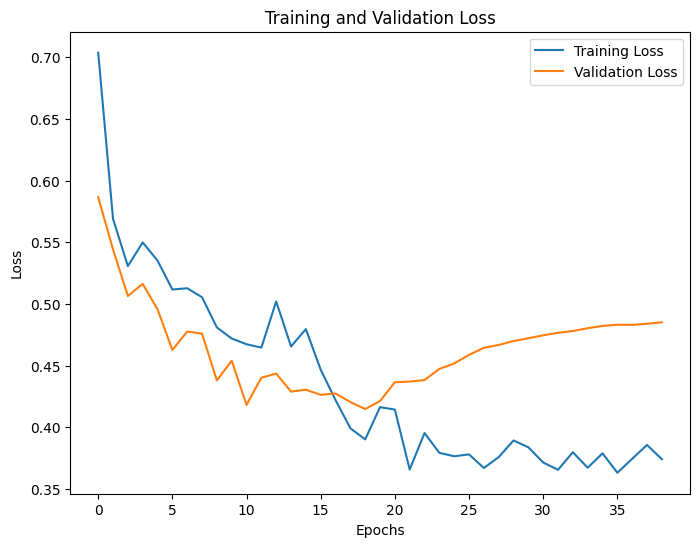

3/3 [==============================] - 1s 9ms/step - loss: 0.4207 - recall: 0.9750 - auc: 0.8951 - false_negatives: 1.0000 - accuracy: 0.8493
Test Recall: 0.9750000238418579
Test AUC: 0.895075798034668
Test FN: 1.0
Test Accuracy: 0.8493150472640991
3/3 [==============================] - 0s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81        33
           1       0.80      0.97      0.88        40

    accuracy                           0.85        73
   macro avg       0.88      0.84      0.84        73
weighted avg       0.87      0.85      0.85        73



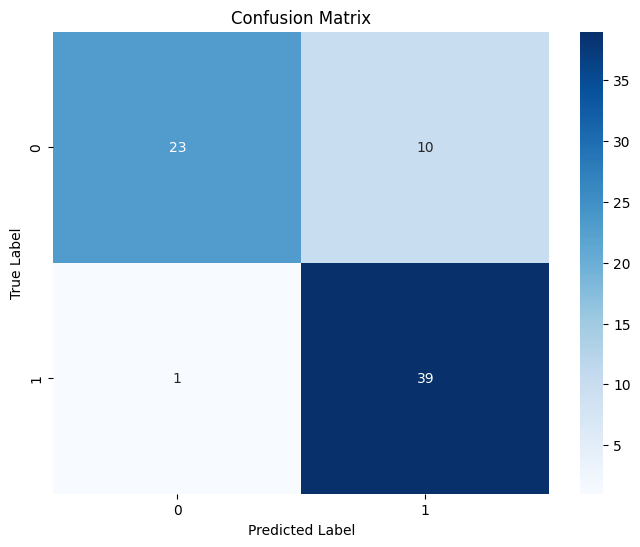

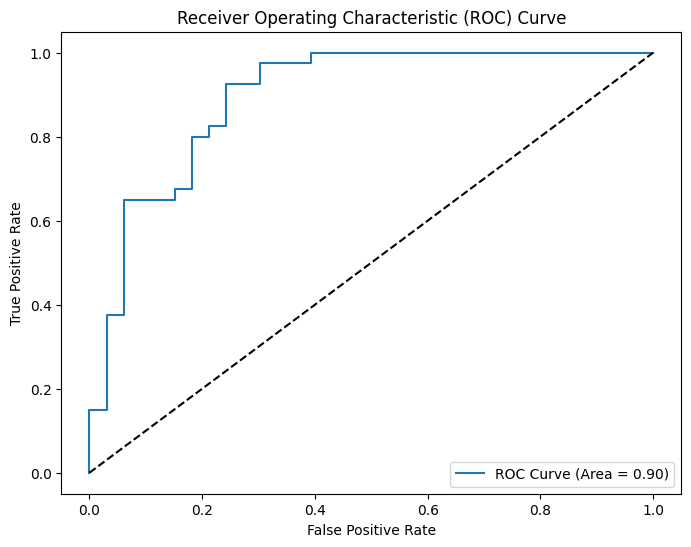

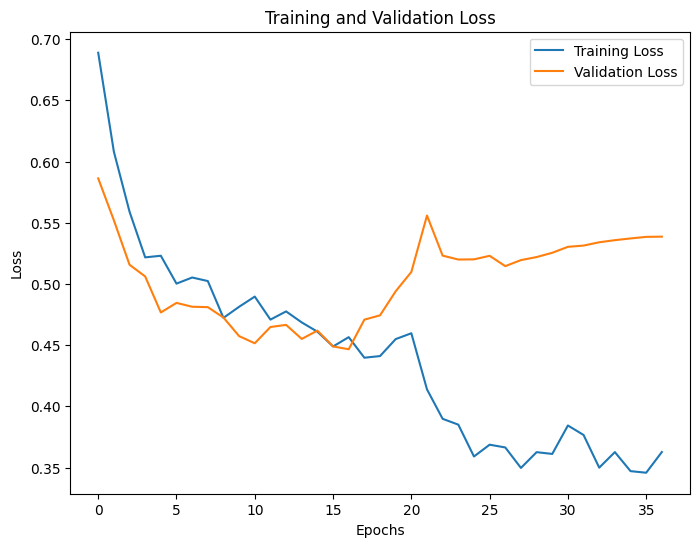

Mean AUC: 0.8842 (+/- 0.0249)
Mean F1 Score: 0.8156 (+/- 0.0269)
Mean FN Rate: 0.0795 (+/- 0.0419)
Mean Accuracy: 0.8192 (+/- 0.0251)


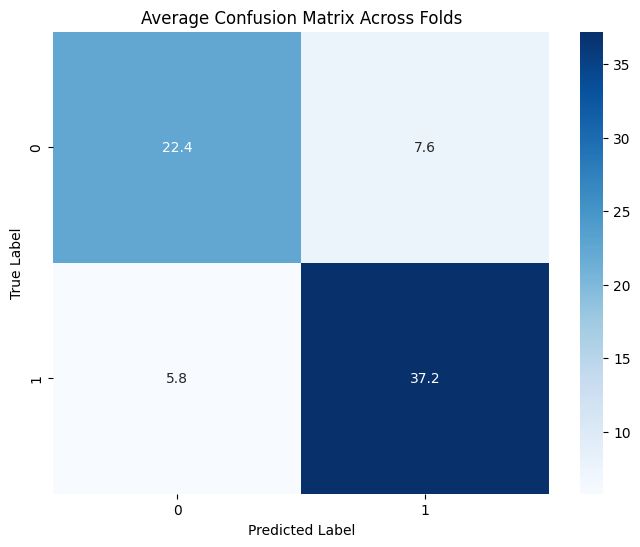

In [38]:
# Number of folds for Stratified K-fold
n_splits = 5

# Weights of the classes
class_weight = {0: 1, 1: 1.5}

optimize.CV_NN_stats(X, y, n_splits, class_weight, 'NN')

warnings.filterwarnings('ignore')

The resulst of the Neural Network are satisfactory but not that better than those obtained with the other models. 

Thus, in the end we would probably resort to a simpler and more explainable model like Logistic Regression since their performances are quite similar.

| Model                        | Logistic Regression | Linear Discriminant Analysis | Random Forest | SVM   | CNN  | NN   |
|------------------------------|---------------------|------------------------------|---------------|-------|------|------|
| F1                           | 0.79                | 0.80                         | 0.81          | 0.78  |  0.8293 (+/- 0.0356)    |  0.7931 (+/- 0.0508)    |
| AUC-ROC                      | 0.87                | 0.88                         | 0.89          | 0.87  |  0.8776 (+/- 0.0255)  |   0.8623 (+/- 0.0490)   |
| Accuracy                     | 0.79                | 0.75                         | 0.81          | 0.80  |      |      |
| Precision                    | 0.79                | 0.79                         | 0.81          | 0.80  |      |      |
